In [874]:
# # запускати один раз, потім можна закрити коментами
# !python.exe -m pip install --upgrade pip
# !pip3 install paddlepaddle
# !pip3 install paddleocr

In [875]:
import cv2
import os
import numpy as np
from datetime import datetime
from keras.models import load_model
from matplotlib import pyplot as plt

In [876]:
car_photo = "../images/AE1455KH_f.jpg"

In [877]:
# Функції

def display(img_, title=""):
    '''
    функція виводу зображень з заголовком
    '''
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()


def detect_plate(img, text=""):
    """
    Функція призначена для виявлення та обробки номерних знаків на зображенні.

    Параметри:
    img (numpy.array): Зображення, на якому потрібно виявити та обробити номерні знаки.
    text (str, optional): Текст, який можна додати на зображення навколо номерного знаку.

    Повертає:
    numpy.array: Зображення з виділеними номерними знаками та, за бажанням, доданим текстом.
    numpy.array or None: Зображення області номерного знаку для подальшої обробки або None, якщо номерний знак не був виявлений.
    """
    plate_img = img.copy()  # перша копія зображення
    reg_of_intr = img.copy()  # друга копія зображення

    # виявляє номерні знаки та повертає координати та розміри виявлених контурів номерних знаків
    plate_rect = plate_cascade.detectMultiScale(
        plate_img, scaleFactor=1.4, minNeighbors=7
    )

    # print(f"{plate_rect = }")
    plate_rect = plate_rect[[1]]
    # print(f"{plate_rect = }")

    # виділення частини номерного знака для розпізнавання
    for x, y, w, h in plate_rect:
        plate = reg_of_intr[y : y + h, x : x + w, :]
        # print(f"{plate = }")
        # малювання прямокутника по межі номера
        cv2.rectangle(plate_img, (x + 2, y), (x + w - 3, y + h - 5), (51, 181, 155), 3)

    # Додавання тексту
    if text != "":
        plate_img = cv2.putText(
            plate_img,
            text,
            (x - w // 2, y - h // 2),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            0.5,
            (51, 181, 155),
            1,
            cv2.LINE_AA,
        )

    # Повертаємо оброблене зображення з виділеними номерними знаками та область номерного знаку
    return plate_img, plate



def find_contours(dimensions, img, echo=True):
    """
    Функція призначена для знаходження контурів символів на зображенні номерного знака.

    Параметри:
        dimensions (list): Список, що містить набір розмірів контурів символів:
                           lower_width, upper_width, lower_height та upper_height.
        img (numpy.ndarray): Вхідне зображення, на якому потрібно знайти контури символів.

    Повертає:
        numpy.ndarray: Масив, що містить зображення контурів символів, відсортованих за координатою x.
    """

    # Знайти всі контури на зображенні
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Отримати потенційні розміри
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread("../../tmp/contour.jpg")

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if (
            intWidth > lower_width
            and intWidth < upper_width
            and intHeight > lower_height
            and intHeight < upper_height
        ):
            x_cntr_list.append(
                intX
            )  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY : intY + intHeight, intX : intX + intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(
                ii, (intX, intY), (intWidth + intX, intY + intHeight), (76, 202, 102), 2
            )
            if echo:
                plt.imshow(ii, cmap="gray")

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(
                char_copy
            )  # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    # if echo:
    #     plt.show()

    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(
            img_res[idx]
        )  
    img_res = np.array(img_res_copy)

    return img_res


def segment_characters(image, echo=True):
    """
    Знаходить символи на зображенні номерного знака.

    Параметри:
     - image: Зображення номерного знака, з якого будуть вилучені символи.

    Повертає:
     - char_list: Список контурів символів, знайдених на зображенні.
    """
    # Попередньо оброблюємо зображення номерного знака
    img_lp = cv2.resize(image, (333, 75))  # Resize the image to a fixed size
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Apply binary thresholding
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Apply erosion to remove noise
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    # Apply dilation to restore original size
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]  # Get the width of the license plate
    LP_HEIGHT = img_binary_lp.shape[1]  # Get the height of the license plate

    # Робимо межі білими
    img_binary_lp[0:3, :] = 255  # Minimum character height
    img_binary_lp[:, 0:3] = 255  # Maximum character height
    img_binary_lp[72:75, :] = 255  # Minimum character width
    img_binary_lp[:, 330:333] = 255  # Maximum character width

    # Приблизні розміри контурів символів обрізаного номерного знака
    dimensions = [LP_WIDTH / 6, LP_WIDTH / 2, LP_HEIGHT / 10, 2 * LP_HEIGHT / 3]

    if echo:
        plt.imshow(img_binary_lp, cmap="gray")  # Display the binary image
    if echo:
        plt.show()

    # Save the binary image to a file
    cv2.imwrite("../../tmp/contour.jpg", img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp, echo=False)  # Find character contours

    return char_list  # Return the list of character contours


def fix_dimension(img):
    """
    Функція для вирівнювання розмірів зображення до розмірів (28, 28, 3).

    Параметри:
    img (numpy.ndarray): Вхідне зображення з розмірами (n, m), де n та m - цілі числа.

    Повертає:
    numpy.ndarray: Зображення з розмірами (28, 28, 3), де 3 - кількість каналів (RGB).
    """
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


def show_results(char):
    """
    Функція для показу результатів розпізнавання символів на номерному знаку.

    Параметри:
    char (list): Список зображень символів номерного знаку.

    Повертає:
    str: Рядок, що містить розпізнану номерну знаку, складену з окремих символів.
    """
    dic = {}
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i, c in enumerate(characters):
        dic[i] = c
    # print(dic)

    output = []
    for i, ch in enumerate(char):  # ітеруємося по символах
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # підготовка зображення для моделі
        y_proba = model.predict(img, verbose=0)[
            0
        ]  # отримуємо ймовірності для кожного класу
        y_ = np.argmax(y_proba)  # вибираємо клас з найвищою ймовірністю
        character = dic[y_]  # отримуємо символ, відповідний прогнозованому класу
        output.append(character)  # зберігаємо результат у списку

    plate_number = "".join(output)  # об'єднуємо всі символи у рядок

    return plate_number



def display_result(img_, title="", recognized_text="", font_scale=2, font_thickness=3):
    # Copy the image to avoid modifying the original one
    img = img_.copy()

    # Font settings for OpenCV
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Calculate the position for the text near the bottom of the image
    # text_position = (50, 100)  # Starting position for the text
    img_height, img_width = img.shape[:2]
    text_position = (50, img_height - 50)

    # Calculate the size of the text box
    (text_width, text_height), baseline = cv2.getTextSize(
        recognized_text, font, font_scale, font_thickness
    )

    # Calculate the coordinates for the white rectangle
    box_coords = (
        (text_position[0] - 10, text_position[1] + baseline - text_height - 30),
        (text_position[0] + text_width + 10, text_position[1] + baseline - 10),
    )

    # Draw the white rectangle
    cv2.rectangle(img, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)

    # Add recognized text to the image
    cv2.putText(
        img,
        recognized_text,
        text_position,
        font,
        font_scale,
        (0, 255, 0),
        font_thickness,
        cv2.LINE_AA,
    )

    display(img, title=title)
    
    # Convert the image from BGR to RGB for displaying with matplotlib
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # # Display the image with the title
    # plt.figure(figsize=(10, 6))
    # ax = plt.subplot(111)
    # ax.imshow(img)
    # plt.axis("off")
    # plt.title(title, fontsize=20)
    # plt.show()

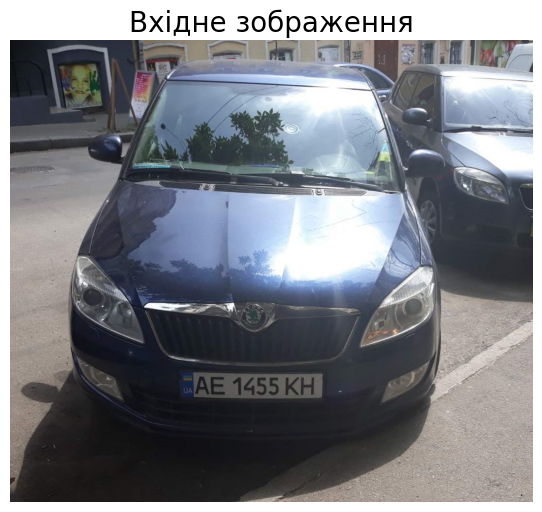

In [878]:
# loading the data required for detecting the license plates using cascade classifier.
current_dir = os.getcwd()
plate_cascade_path = os.path.join(
    current_dir, "../models/haarcascade_ua_license_plate.xml"
)
plate_cascade = cv2.CascadeClassifier(
    plate_cascade_path
)  

# car_photo = "../images/AE1455KH_f.jpg"
image_path = os.path.join(current_dir, car_photo)
img = cv2.imread(image_path)
display(img, "Вхідне зображення")

## Use Model Keras for character recognition

In [879]:
MODEL = "../models/model_ua_license_plate.keras"

In [880]:
model = load_model(MODEL, compile=False)
output_img, plate = detect_plate(img)
plate_number = show_results(segment_characters(plate, echo=False))
print("\033[33m\t", plate_number, "\033[0m")

	 AE1455KH 


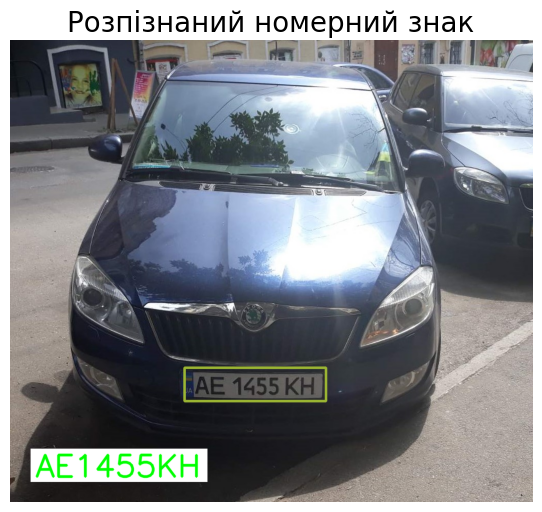

In [881]:
display_result(
    output_img, title="Розпізнаний номерний знак", recognized_text=plate_number
)